# Double-Bracket Iteration Strategy: magnetic field (Ising model)
This notebook shows the diagonalization process of DBI using the magnetic field strategy, which varies the diagonal operator $D$ by gradient descent. To find the gradient with respect to $D$, parameterization of $D$ is required. For the purpose of this notebook, we represent it by the Ising model, i.e.

$$ D = \sum \alpha_i Z_i +\sum \beta_{ij}Z_iZ_j$$


The gradients are calculated under the premise that the diagonalization gain curve can be fitted by a polynomial, and that the iteration step duration is taken at the first dip of the curve.

In [1]:
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

from qibo import hamiltonians, set_backend, symbols
from qibo.hamiltonians import Hamiltonian, SymbolicHamiltonian
from qibo.quantum_info import random_hermitian
from qibo.models.dbi.double_bracket import DoubleBracketGeneratorType, DoubleBracketScheduling, DoubleBracketIteration
from qibo.models.dbi.utils import generate_pauli_operator_dict, decompose_into_pauli_basis, ParameterizationTypes
from qibo.models.dbi.utils_dbr_strategies import gradient_numerical, gradient_descent

In [2]:
def visualize_matrix(matrix, title=""):
    """Visualize hamiltonian in a heatmap form."""
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title)
    try:
        im = ax.imshow(np.absolute(matrix), cmap="inferno")
    except TypeError:
        im = ax.imshow(np.absolute(matrix.get()), cmap="inferno")
    fig.colorbar(im, ax=ax)


## Test on random Hamiltonian

[Qibo 0.2.8|INFO|2024-06-05 13:52:35]: Using numpy backend on /CPU:0


Initial off diagonal norm 31.576176740060667


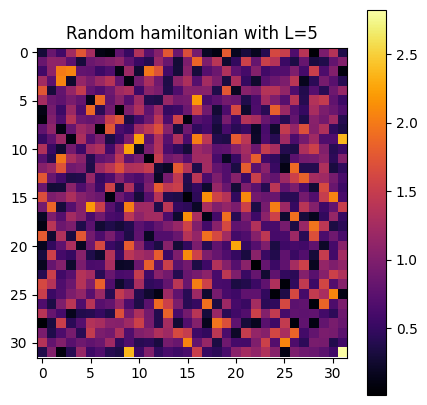

In [3]:
# backend
set_backend("numpy")
# initialize dbi object
nqubits = 5
h0 = random_hermitian(2**nqubits, seed=2)
scheduling = DoubleBracketScheduling.hyperopt
mode = DoubleBracketGeneratorType.single_commutator
n_taylor = 5
dbi = DoubleBracketIteration(Hamiltonian(nqubits=nqubits, matrix=h0), scheduling=scheduling, mode=mode)
print("Initial off diagonal norm", dbi.off_diagonal_norm)
visualize_matrix(dbi.h.matrix, title=f'Random hamiltonian with L={nqubits}')

### Order 1: $D=\sum \alpha_iZ_i$

In [4]:
# generate pauli_operator_dict
pauli_operator_dict = generate_pauli_operator_dict(nqubits=nqubits, parameterization_order=1)
d_coef = decompose_into_pauli_basis(dbi.h.matrix, list(pauli_operator_dict.values()))
d = sum([d_coef[i] * list(pauli_operator_dict.values())[i] for i in range(nqubits)])
grad = gradient_numerical(dbi, d_coef, parameterization=ParameterizationTypes.pauli, pauli_operator_dict=pauli_operator_dict)
print('The initial D coefficients:', d_coef)
print('Gradient:', grad)

[Qibo 0.2.8|WARNING|2024-06-05 13:52:45]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.8|WARNING|2024-06-05 13:52:45]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.8|WARNING|2024-06-05 13:52:45]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.8|WARNING|2024-06-05 13:52:45]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.8|WARNING|2024-06-05 13:52:45]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


The initial D coefficients: [(-0.2980910136757636+0j), (-0.17678355790937256+0j), (0.294550421681131+0j), (-0.2301056409534723+0j), (-0.07297191764284382+0j)]
Gradient: [ 0.30244158  0.14052436 -0.27365959  0.22888805  0.0385471 ]


In [5]:
iters = 15
off_diagonal_norm_1, d_params_hist, s_step = gradient_descent(dbi, iters, d_coef, parameterization=ParameterizationTypes.pauli, pauli_operator_dict=pauli_operator_dict)

Text(0, 0.5, '$|| \\sigma(e^{sW}He^{-sW}) || $')

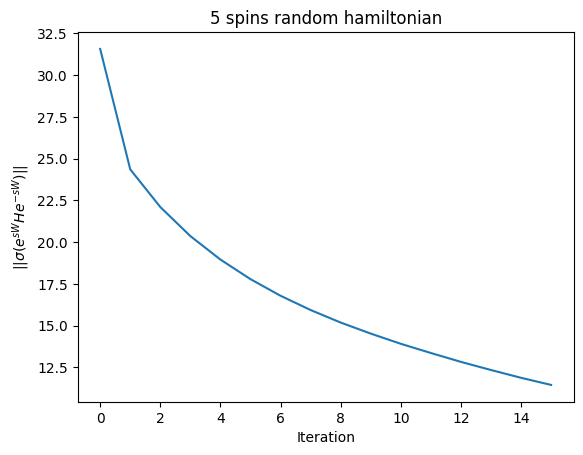

In [6]:
plt.title(str(nqubits) + ' spins random hamiltonian')
plt.plot(off_diagonal_norm_1)
plt.xlabel('Iteration')
plt.ylabel(r'$|| \sigma(e^{sW}He^{-sW}) || $')

### Order 2: $D=\sum \alpha_iZ_i + \beta_{ij}Z_iZ_j$

In [7]:
dbi = DoubleBracketIteration(Hamiltonian(nqubits=nqubits, matrix=h0), scheduling=scheduling, mode=mode)

In [8]:
# generate pauli_operator_dict
pauli_operator_dict = generate_pauli_operator_dict(nqubits=nqubits, parameterization_order=2)
d_coef = decompose_into_pauli_basis(dbi.h.matrix, list(pauli_operator_dict.values()))
d = sum([d_coef[i] * list(pauli_operator_dict.values())[i] for i in range(nqubits)])
grad = gradient_numerical(dbi, d_coef, parameterization=ParameterizationTypes.pauli, pauli_operator_dict=pauli_operator_dict)
print('The initial D coefficients:', d_coef)
print('Gradient:', grad)

[Qibo 0.2.8|WARNING|2024-06-05 15:14:08]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.8|WARNING|2024-06-05 15:14:08]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.8|WARNING|2024-06-05 15:14:08]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.8|WARNING|2024-06-05 15:14:08]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.8|WARNING|2024-06-05 15:14:08]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.8|WARNING|2024-06-05 15:14:08]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.8|WARNING|2024-06-05 15:14:08]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.8|WARNING|2024-06-05 15:14:08]: Calculating the dens

The initial D coefficients: [(-0.2980910136757636+0j), (-0.17678355790937256+0j), (0.294550421681131+0j), (-0.2301056409534723+0j), (-0.07297191764284382+0j), (0.15766557989586075+0j), (0.1267267343988193+0j), (0.10801310050393904+0j), (0.37981790024704787+0j), (0.25748679935414437+0j), (-0.2531727610451514+0j), (0.13345922163435078+0j), (-0.02961684041039575+0j), (0.36206828748686004+0j), (0.12254924877248492+0j)]
Gradient: [ 0.30244158  0.14052436 -0.27365959  0.22888805  0.0385471   0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


In [9]:
iters = 15
off_diagonal_norm_2, d_params_hist, s_step = gradient_descent(dbi, iters, d_coef, parameterization=ParameterizationTypes.pauli, pauli_operator_dict=pauli_operator_dict)

Text(0, 0.5, '$|| \\sigma(e^{sW}He^{-sW}) || $')

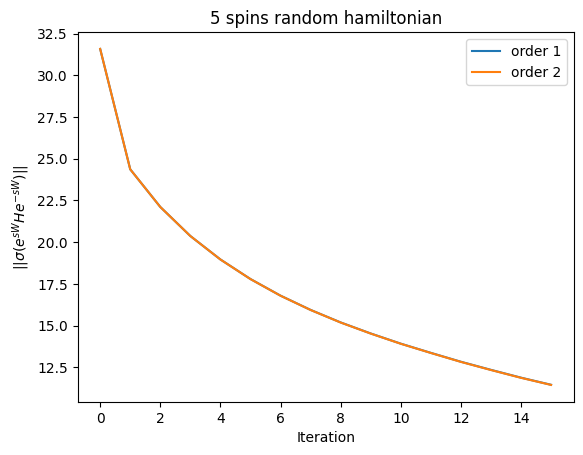

In [10]:
plt.title(str(nqubits) + ' spins random hamiltonian')
plt.plot(off_diagonal_norm_1, label='order 1')
plt.plot(off_diagonal_norm_2, label='order 2')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel(r'$|| \sigma(e^{sW}He^{-sW}) || $')

## Test on TFIM
Here we choose to customize our TFIM in the X axis using `SymbolicHamiltonian`. It is also possible to use Hadamard gate to rotate the TFIM inbuilt in `qibo`.

$$ H = -(\sum X_i X_{i+1} + \sum hZ_i)

[Qibo 0.2.8|WARNING|2024-06-05 15:18:43]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


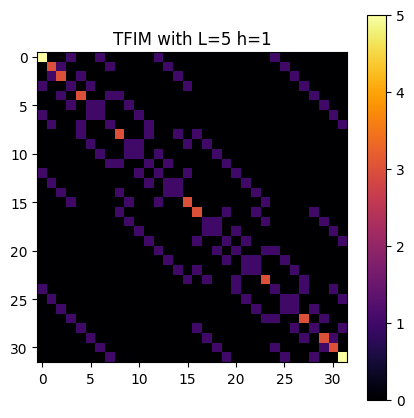

In [11]:
# generate the Hamiltonian
nqubits = 5
h = 1
H_TFIM = SymbolicHamiltonian( - h*symbols.Z(nqubits-1), nqubits=nqubits)
# add linear interaction terms
for i in range(nqubits-1):
    H_TFIM -= SymbolicHamiltonian(symbols.X(i)*symbols.X(i+1) + h*symbols.Z(i), nqubits=nqubits)
H_TFIM = H_TFIM.dense
visualize_matrix(H_TFIM.matrix, title=f'TFIM with L={nqubits} h={h}')

In [12]:
# backend
set_backend("numpy")
# initialize dbi object
dbi_TFIM = DoubleBracketIteration(deepcopy(H_TFIM), scheduling=scheduling, mode=mode)

[Qibo 0.2.8|INFO|2024-06-05 15:18:43]: Using numpy backend on /CPU:0


### Order 1: $D=\sum \alpha_iZ_i$

In [13]:
dbi_TFIM_1 = DoubleBracketIteration(deepcopy(H_TFIM), scheduling=scheduling, mode=mode)
# generate pauli_operator_dict
pauli_operator_dict = generate_pauli_operator_dict(nqubits=nqubits, parameterization_order=1)
d_coef = decompose_into_pauli_basis(dbi_TFIM_1.h.matrix, list(pauli_operator_dict.values()))
d = sum([d_coef[i] * list(pauli_operator_dict.values())[i] for i in range(nqubits)])
grad = gradient_numerical(dbi_TFIM_1, d_coef, parameterization=ParameterizationTypes.pauli, pauli_operator_dict=pauli_operator_dict)
print('The initial D coefficients:', d_coef)
print('Gradient:', grad)

[Qibo 0.2.8|WARNING|2024-06-05 15:18:43]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.8|WARNING|2024-06-05 15:18:43]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.8|WARNING|2024-06-05 15:18:43]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.8|WARNING|2024-06-05 15:18:43]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.8|WARNING|2024-06-05 15:18:43]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


The initial D coefficients: [(-1+0j), (-1+0j), (-1+0j), (-1+0j), (-1+0j)]
Gradient: [0.10602642 0.21966074 0.21908701 0.21966074 0.10602642]


In [14]:
NSTEPS = 3
off_diagonal_norm_1, d_params_hist, s_step = gradient_descent(dbi_TFIM_1, NSTEPS, d_coef, parameterization=ParameterizationTypes.pauli, pauli_operator_dict=pauli_operator_dict)

Text(0, 0.5, '$|| \\sigma(e^{sW}He^{-sW}) || $')

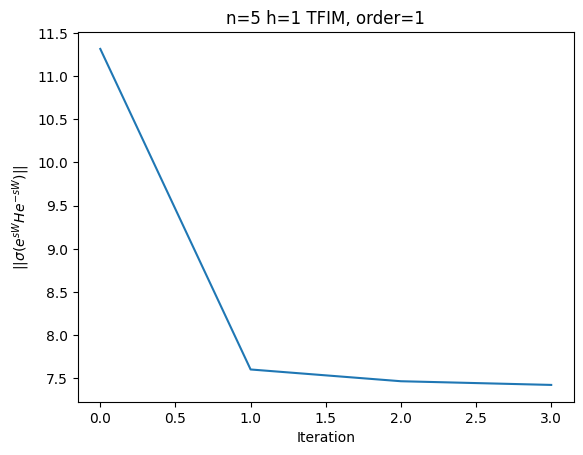

In [15]:
plt.title(f'n={nqubits} h={h} TFIM, order=1')
plt.plot(off_diagonal_norm_1)
plt.xlabel('Iteration')
plt.ylabel(r'$|| \sigma(e^{sW}He^{-sW}) || $')

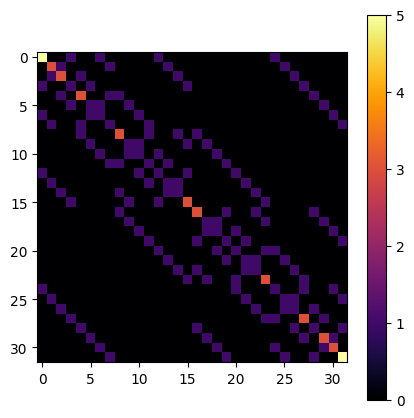

In [16]:
# the final matrix
visualize_matrix(dbi_TFIM.h.matrix)

### Order 2

In [17]:
dbi_TFIM_2 = DoubleBracketIteration(deepcopy(H_TFIM), scheduling=scheduling, mode=mode)
# generate pauli_operator_dict
pauli_operator_dict = generate_pauli_operator_dict(nqubits=nqubits, parameterization_order=2)
d_coef = decompose_into_pauli_basis(dbi_TFIM_2.h.matrix, list(pauli_operator_dict.values()))
d = sum([d_coef[i] * list(pauli_operator_dict.values())[i] for i in range(nqubits)])
grad = gradient_numerical(dbi_TFIM_2, d_coef, parameterization=ParameterizationTypes.pauli, pauli_operator_dict=pauli_operator_dict)
print('The initial D coefficients:', d_coef)
print('Gradient:', grad)

[Qibo 0.2.8|WARNING|2024-06-05 15:20:07]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.8|WARNING|2024-06-05 15:20:07]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.8|WARNING|2024-06-05 15:20:07]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.8|WARNING|2024-06-05 15:20:07]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.8|WARNING|2024-06-05 15:20:07]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.8|WARNING|2024-06-05 15:20:07]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.8|WARNING|2024-06-05 15:20:07]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.8|WARNING|2024-06-05 15:20:07]: Calculating the dens

The initial D coefficients: [(-1+0j), (-1+0j), (-1+0j), (-1+0j), (-1+0j), 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j]
Gradient: [0.10602642 0.21966074 0.21908701 0.21966074 0.10602642 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


In [18]:
off_diagonal_norm_2, d_params_hist, s_step = gradient_descent(dbi_TFIM_2, NSTEPS, d_coef, parameterization=ParameterizationTypes.pauli, pauli_operator_dict=pauli_operator_dict)

Text(0, 0.5, '$|| \\sigma(e^{sW}He^{-sW}) || $')

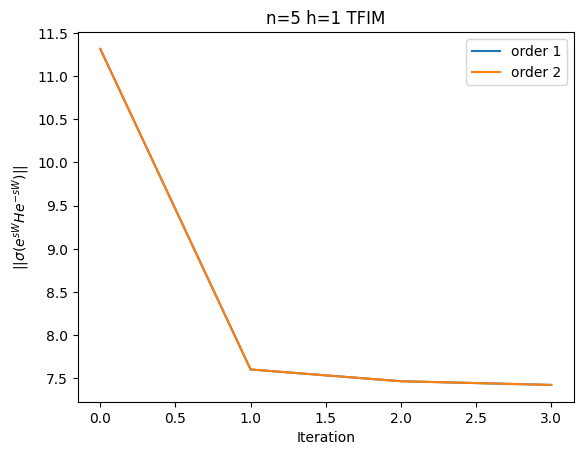

In [19]:
plt.title(f'n={nqubits} h={h} TFIM')
plt.plot(off_diagonal_norm_1, label='order 1')
plt.plot(off_diagonal_norm_2, label='order 2')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel(r'$|| \sigma(e^{sW}He^{-sW}) || $')

In conclusion, we see that the parameterization order or locality of the Pauli based parameterization for gradient descent does not affect significantly the effectiveness of double bracket diagonalization.